# Machine Learning for Finance in Python

## Chapter 1

In [31]:
from datetime import datetime
import talib
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [19]:
start_date_string = "2016-04-15"
end_date_string = "2018-04-10"

lng_df_all = pd.read_csv("LNG.csv")
lng_df_all.set_index("Date", inplace=True)
lng_df = lng_df_all.loc[start_date_string:end_date_string].copy()

spy_df_all = pd.read_csv("SPY.csv")
spy_df_all.set_index("Date", inplace=True)
spy_df = spy_df_all.loc[start_date_string:end_date_string].copy()

print(lng_df)
print(spy_df)

            Adj_Close  Adj_Volume
Date                             
2016-04-15      37.13   4293775.0
2016-04-18      36.90   3445852.0
2016-04-19      37.12   3748050.0
2016-04-20      37.77   2470384.0
2016-04-21      37.21   2043988.0
...               ...         ...
2018-04-04      54.30   1816771.0
2018-04-05      56.21   2533635.0
2018-04-06      54.36   1754446.0
2018-04-09      54.10   1203998.0
2018-04-10      55.63   3430268.0

[500 rows x 2 columns]
             Adj_Close   Adj_Volume
Date                               
2016-04-15  199.760673   75761600.0
2016-04-18  201.164330   75277700.0
2016-04-19  201.798846   88316100.0
2016-04-20  201.991139   81100300.0
2016-04-21  200.904747   85695000.0
...                ...          ...
2018-04-04  263.560000  123574054.0
2018-04-05  265.640000   80993290.0
2018-04-06  259.720000  179483634.0
2018-04-09  261.000000  105442932.0
2018-04-10  265.150000  105383213.0

[500 rows x 2 columns]


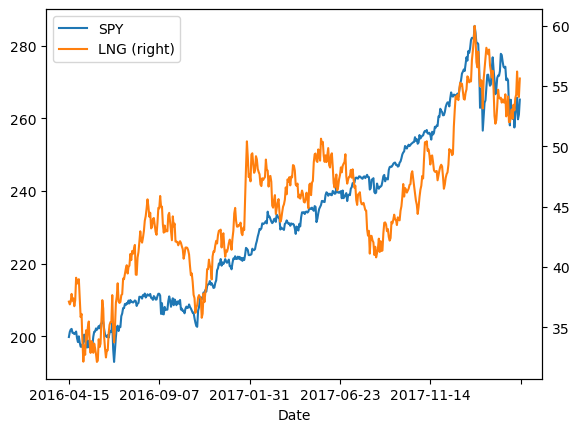

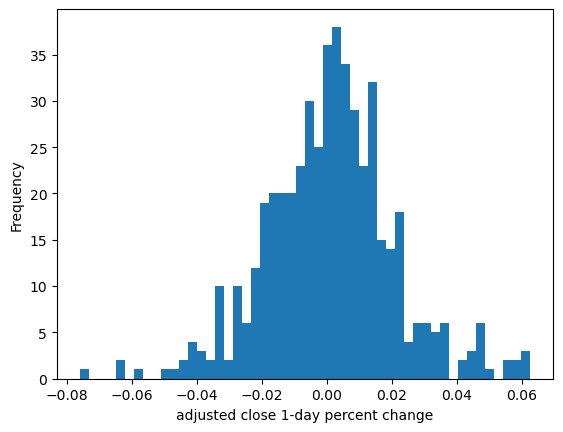

In [20]:
# Plot the Adj_Close columns for SPY and LNG
spy_df["Adj_Close"].plot(label='SPY', legend=True)
lng_df["Adj_Close"].plot(label="LNG", legend=True, secondary_y=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change(1).plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.164861
5d_close_future_pct     -0.164861             1.000000


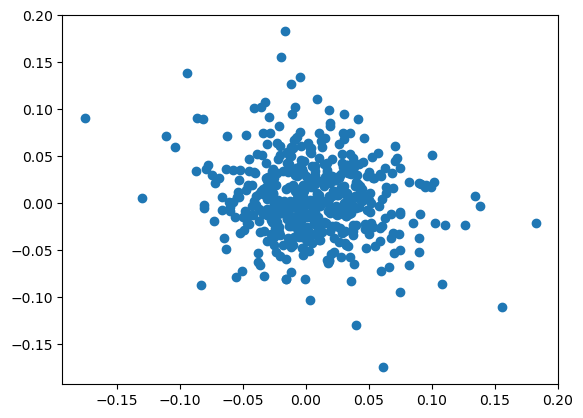

In [21]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

In [22]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df["Adj_Close"]
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [23]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000     -0.047183  0.096373 -0.068888   
5d_close_pct                   -0.047183      1.000000 -0.827699  0.683973   
ma14                            0.096373     -0.827699  1.000000 -0.877566   
rsi14                          -0.068888      0.683973 -0.877566  1.000000   
ma30                            0.102744     -0.609573  0.848778 -0.964795   
rsi30                          -0.106279      0.518748 -0.713427  0.935711   
ma50                            0.113444     -0.475081  0.692689 -0.916540   
rsi50                          -0.138946      0.426045 -0.601849  0.845788   
ma200                           0.230860     -0.220690  0.346457 -0.551087   
rsi200                         -0.221029      0.284021 -0.416221  0.639057   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct  0.102744 -0.106279  0.113444 -0.138946  0.23086

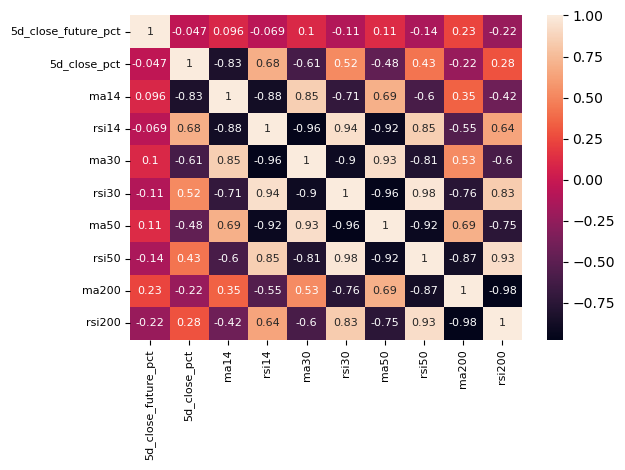

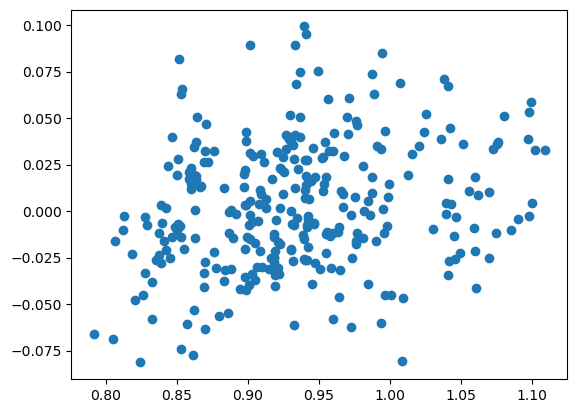

In [30]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True, annot_kws = {"size": 8})
plt.yticks(rotation=0, size = 8); plt.xticks(rotation=90, size = 8)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(lng_df["ma200"], lng_df["5d_close_future_pct"])
plt.show()

In [32]:
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(295, 10) (250, 10) (45, 10)


In [33]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.273
Model:                             OLS   Adj. R-squared:                  0.246
Method:                  Least Squares   F-statistic:                     10.01
Date:                 Mon, 18 Sep 2023   Prob (F-statistic):           4.92e-13
Time:                         18:13:15   Log-Likelihood:                 536.49
No. Observations:                  250   AIC:                            -1053.
Df Residuals:                      240   BIC:                            -1018.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8197      1.169    

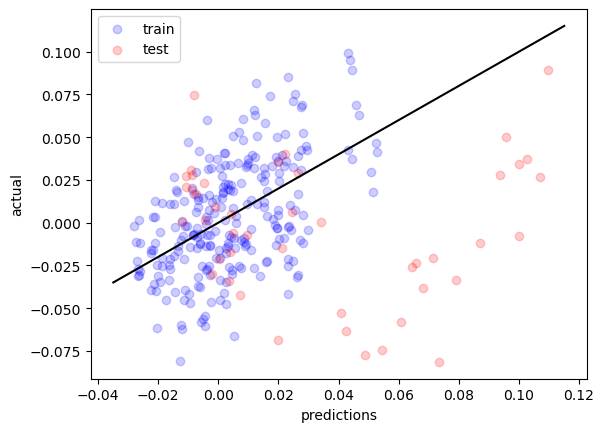

In [34]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha = 0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

We can see our predictions are ok, but not very good yet. We need non-linearity.